# Interbank Network Simulation (Refined)

Using the Furfine Algorithm, we calculate the effect of a random bank default in the setting of an Erdos-Renyi network. This is done as follows:

1. Create a bank object with a fixed balance sheet. 
2. Initialise a network where nodes are banks and edges are interbank loans.
   - A network is connected to another network if a number chosen at random is smaller than some probability p.
3. Randomly default one of the banks in the network by setting their assets to zero. 
4. Recalculate the total assets of each bank connected to the defaulted bank.
   - To do this, subtract the defaulted bank's interbank liability from its neighbouring banks' assets.
5. If for the neighbouring banks' assets are now less than zero, mark this as another default and repeat step 3 onwards modelling the defaulting bank as this bank.


## Generate a Random Financial Network

In [13]:
EXTERNAL_ASSETS = 0.8
NUMBER_OF_DEFAULT = 0

In [14]:
class Bank(object):
    def __init__(self, bank_id, interbank_assets=0.2, liabilities=0.96, default=False):
        self.bank_id = bank_id
        self.interbank_assets = interbank_assets
        self.liabilities = liabilities
        self.default = default
        self.bank_connected = [] #List of banks it owes money to
        self.bank_lent = 0 #Number of banks owing money from it
        self.edges = [] # Elements of edges: (the bank itself, the bank it borrows money from, the amount of liabilities)
        
    # For NetworkX to label the bank based on ID.
    def __str__(self):
        return str(self.bank_id)
    
    # This function is called when the bank connected to 'self' defaults, transmitting its loss to the asset.
    def update_total_assets(self, loss):
        self.interbank_assets -= loss 
        global EXTERNAL_ASSETS
        if(EXTERNAL_ASSETS + self.interbank_assets < self.liabilities):
            NUMBER_OF_DEFAULT = 0
            self.default_bank()
        
    # This function is called every time 'self' borrows money from a new bank.  
    def update_connection(self, bank):
        self.bank_connected.append(bank)
        bank.bank_lent += 1
    
    # This function is called when the bank is set to default.
    def default_bank(self):
        self.default = True
        for bank in self.bank_connected:
            if (bank.default==False):
                bank.update_total_assets(self.interbank_assets/self.bank_lent)
    
    def total_assets(self):
        return self.interbank_assets + EXTERNAL_ASSETS

## Generate the Graph

In [21]:
class Graph(object):
    def __init__(self, bank_number=5, borrow_probability=0.25, iteration=10):
        self.bank_number = bank_number
        self.borrow_probability = borrow_probability
        self.bank_list = []
        self.iteration = iteration
        self.global_cascades = 0
    
    # Generate random banks and random connections between banks.
    def generate_bank(self):
        for i in range(self.bank_number):
            newBank = Bank(bank_id=i)
            self.bank_list.append(newBank)
        
        potential_lender = self.bank_list.copy()
        
        for bank in self.bank_list:
            for lender in potential_lender:
                import random
                tendency = random.uniform(0, 1) # Generate random number. The lower, the higher chance of a connection.
                if(bank!=lender and tendency < self.borrow_probability):
                    bank.update_connection(lender)
        
        self.random_default_bank()
        self.print_banks_status()
        if(NUMBER_OF_DEFAULT/self.bank_number >= 0.05):
            self.global_cascades += 1
        
    def draw_graph(self):
        for i in range(0,self.iteration):
            global NUMBER_OF_DEFAULT
            NUMBER_OF_DEFAULT = 0
            self.generate_bank()
            
        self.store_data()
        
    def print_banks_status(self):
        global NUMBER_OF_DEFAULT
        print("Total Number of Defaults ", NUMBER_OF_DEFAULT)
            
    def random_default_bank(self):
        import random
        random_bank = random.choice(self.bank_list)
        print("The bank chosen to default is Bank" , random_bank.bank_id)
        random_bank.default_bank()
        
    def store_data(self):
        import json
        average_degree = self.borrow_probability * self.bank_number
        prob_contagion = self.global_cascades/self.iteration
        print("Average Degree : ", average_degree , "Probability of Contagion : ", prob_contagion)
        with open('data.json') as f:
            data = json.loads(f.read())
            data[average_degree] = prob_contagion
            print(data)
            with open('data.json', 'w') as f:
                json.dump(data, f)

## Initialise and Display Graph

In [29]:
graph = Graph(bank_number=300, borrow_probability=0.2)
import time
past_time = time.time()
graph.draw_graph()
print("time : ", time.time() - past_time)

The bank chosen to default is Bank 219
Total Number of Defaults  0
The bank chosen to default is Bank 93
Total Number of Defaults  0
The bank chosen to default is Bank 265
Total Number of Defaults  0
The bank chosen to default is Bank 24
Total Number of Defaults  0
The bank chosen to default is Bank 88
Total Number of Defaults  0
The bank chosen to default is Bank 264
Total Number of Defaults  0
The bank chosen to default is Bank 25
Total Number of Defaults  0
The bank chosen to default is Bank 16
Total Number of Defaults  0
The bank chosen to default is Bank 189
Total Number of Defaults  0
The bank chosen to default is Bank 26
Total Number of Defaults  0
Average Degree :  60.0 Probability of Contagion :  0.0
{'40.0': 0.0, 60.0: 0.0}
time :  21.526143789291382


## Plot Graph

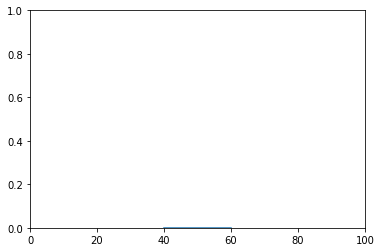

In [30]:
import matplotlib.pyplot as plt
import json

with open('data.json') as f:
    data = json.loads(f.read())
    x_axis = []
    y_axis = []
    for key, value in data.items():
        x_axis.append(float(key))
        y_axis.append(float(value))
    plt.plot(x_axis, y_axis)
    plt.axis([0, 100, 0, 1])
    plt.show()

### Todo:
1. Functions for calculating (a) average degree of a graph and (b) probability of contagion
2. Add graph of average degree (x-axis) against probability of contagion (y-axis).